In [1]:
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from scipy.optimize import curve_fit

In [2]:
#export graphs as svg
import matplotlib as mpl
	
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


In [3]:
# Function to extract the string between "_" and "x" from filename -> to get scale
def extract_string(filename, i = -2): #set i = -2 if it's filename, set i = -1 if it's imagename from the Image column
    match = filename.rsplit("_")
    index = match[i].rsplit("x")
    scale = index [0]
    return scale

# Importing data from .csv folders

* Import all the Results (coordinates) into a dataframe

In [4]:
folder_path = '/Users/mtran/Desktop/bgremoved_fildata_analysis'
total_trace = pl.DataFrame({'Y': [],'X': [],'Contour ID':[],'Image': [], 'Design': [], 'Replicate': []})

for file in glob.glob(os.path.join(folder_path,'*/*/*.csv')): #loop over all folders, search for format .csv
        index = file.rsplit("/")
        filename = index[-1]
        # print(filename)
        image = filename[:filename.rfind('_path_')]
        # print(image)
        path = filename[len(image)+6:filename.rfind('.csv')]
        # print(path)
        
        #Read the csv file currently in the loop
        trace_df = pl.read_csv(file)
        # print(trace_df)
        #Add new columns (these columns are ID columns to trace the data later on) to the DataFrame 
        constant_values = {'Contour ID': path, 'Image': image, 'Design': index[-3], 'Replicate': index[-2]}
        for column_name, value in constant_values.items():
                trace_df = trace_df.with_columns(pl.lit(value).alias(column_name))
        print(trace_df)
        #Merge all the files into one big DataFrame
        total_trace = pl.concat([total_trace,trace_df], how='vertical_relaxed')     
print(total_trace.count()) 

shape: (21, 6)
┌─────┬─────┬────────────┬───────────────────────────────────┬────────┬───────────┐
│ Y   ┆ X   ┆ Contour ID ┆ Image                             ┆ Design ┆ Replicate │
│ --- ┆ --- ┆ ---        ┆ ---                               ┆ ---    ┆ ---       │
│ i64 ┆ i64 ┆ str        ┆ str                               ┆ str    ┆ str       │
╞═════╪═════╪════════════╪═══════════════════════════════════╪════════╪═══════════╡
│ 187 ┆ 37  ┆ 2          ┆ qi-fit-2024.08.01-20.48.12.356_0… ┆ WTwdye ┆ run1      │
│ 186 ┆ 38  ┆ 2          ┆ qi-fit-2024.08.01-20.48.12.356_0… ┆ WTwdye ┆ run1      │
│ 185 ┆ 38  ┆ 2          ┆ qi-fit-2024.08.01-20.48.12.356_0… ┆ WTwdye ┆ run1      │
│ 184 ┆ 39  ┆ 2          ┆ qi-fit-2024.08.01-20.48.12.356_0… ┆ WTwdye ┆ run1      │
│ 183 ┆ 38  ┆ 2          ┆ qi-fit-2024.08.01-20.48.12.356_0… ┆ WTwdye ┆ run1      │
│ …   ┆ …   ┆ …          ┆ …                                 ┆ …      ┆ …         │
│ 171 ┆ 38  ┆ 2          ┆ qi-fit-2024.08.01-20.48.12.356_0… 

* Get a new dataframe with image name, design, run, contour id, and calculate values (Rsq, etc..) for pl extracting


In [5]:
#Group the total_trace df by Image (image name is unique to each file) and Contour ID (each image can contains more than 1 Contour ID)
grouped_total_trace = total_trace.group_by(['Image', 'Contour ID'])
# print(grouped_total_trace)
pixelsize = 5000/256 #pixelsize of the image
    
analyzed_df = pl.DataFrame({'Contour ID':[],'Length': [],'Rsq':[],'Image': [], 'Design': [], 'Replicate': []})

#Loop over the grouped_total_trace to calculate the length, Rsq for each contour
for group_key, group_df in grouped_total_trace: #group_key is a tuple ('Imagename', Contour ID) and group_df is the df of with the group_key
    image, contour_id = group_key
    # print(group_key)
    scale = float(extract_string(image,i=-1))*pixelsize #extract scale from image name and convert to nm
    # print(group_df)

    #Calculate contour length
    coords = group_df[['X', 'Y']].to_numpy()
    distances = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    # print(distances)
    length = np.sum(distances)*scale 

    #Calculate Rsq
    x_coords = group_df['X'].to_numpy()
    y_coords = group_df['Y'].to_numpy()
    Rsq = ((x_coords[-1]*scale-x_coords[0]*scale)**2 + (y_coords[-1]*scale-y_coords[0]*scale)**2)
    # print(Rsq)

    constant_values = {'Contour ID': contour_id, 'Length': length, 'Rsq': Rsq, 'Image': image, 
                        'Design': group_df['Design'][0], 'Replicate': group_df['Replicate'][0]}
    # print(constant_values)
    

    analyzed_df = pl.concat([analyzed_df,pl.DataFrame(constant_values)], how='vertical_relaxed')

        

print(analyzed_df) 
# print(total_coords)        
# print(total_coords['Length'].count())



shape: (753, 6)
┌────────────┬─────────────┬───────────────┬────────────────────────────────┬──────────┬───────────┐
│ Contour ID ┆ Length      ┆ Rsq           ┆ Image                          ┆ Design   ┆ Replicate │
│ ---        ┆ ---         ┆ ---           ┆ ---                            ┆ ---      ┆ ---       │
│ str        ┆ f64         ┆ f64           ┆ str                            ┆ str      ┆ str       │
╞════════════╪═════════════╪═══════════════╪════════════════════════════════╪══════════╪═══════════╡
│ 3          ┆ 1319.57902  ┆ 1.2403e6      ┆ save-2024.07.22-17.02.14.077_1 ┆ iSpiwdye ┆ run1      │
│            ┆             ┆               ┆ .5…                            ┆          ┆           │
│ 10         ┆ 47.152609   ┆ 1907.348633   ┆ qi-fit-2024.07.22-17.05.59.785 ┆ iSpiwdye ┆ run1      │
│            ┆             ┆               ┆ _0…                            ┆          ┆           │
│ 1          ┆ 2682.38467  ┆ 5.9237e6      ┆ qi-fit-2024.08.01-18.56.00.027

shape: (657, 6)
┌────────────┬─────────────┬───────────────┬────────────────────────────────┬──────────┬───────────┐
│ Contour ID ┆ Length      ┆ Rsq           ┆ Image                          ┆ Design   ┆ Replicate │
│ ---        ┆ ---         ┆ ---           ┆ ---                            ┆ ---      ┆ ---       │
│ str        ┆ f64         ┆ f64           ┆ str                            ┆ str      ┆ str       │
╞════════════╪═════════════╪═══════════════╪════════════════════════════════╪══════════╪═══════════╡
│ 3          ┆ 1319.57902  ┆ 1.2403e6      ┆ save-2024.07.22-17.02.14.077_1 ┆ iSpiwdye ┆ run1      │
│            ┆             ┆               ┆ .5…                            ┆          ┆           │
│ 1          ┆ 2682.38467  ┆ 5.9237e6      ┆ qi-fit-2024.08.01-18.56.00.027 ┆ WTwdye   ┆ run1      │
│            ┆             ┆               ┆ _0…                            ┆          ┆           │
│ 1          ┆ 1362.686575 ┆ 542068.481445 ┆ save-2024.08.01-18.52.17.516_1

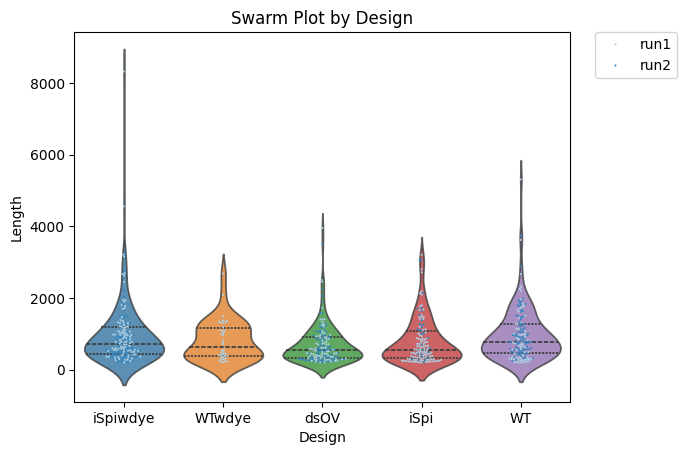

Number of points per replicate:
shape: (9, 3)
┌──────────┬───────────┬───────────┐
│ Design   ┆ Replicate ┆ NumPoints │
│ ---      ┆ ---       ┆ ---       │
│ str      ┆ str       ┆ u32       │
╞══════════╪═══════════╪═══════════╡
│ iSpi     ┆ run2      ┆ 30        │
│ iSpiwdye ┆ run1      ┆ 95        │
│ iSpiwdye ┆ run2      ┆ 80        │
│ WT       ┆ run2      ┆ 83        │
│ WT       ┆ run1      ┆ 69        │
│ iSpi     ┆ run1      ┆ 103       │
│ WTwdye   ┆ run1      ┆ 38        │
│ dsOV     ┆ run1      ┆ 79        │
│ dsOV     ┆ run2      ┆ 80        │
└──────────┴───────────┴───────────┘
shape: (5, 2)
┌──────────┬─────────────┐
│ Design   ┆ TotalCounts │
│ ---      ┆ ---         │
│ str      ┆ u32         │
╞══════════╪═════════════╡
│ WT       ┆ 152         │
│ WTwdye   ┆ 38          │
│ iSpi     ┆ 133         │
│ iSpiwdye ┆ 175         │
│ dsOV     ┆ 159         │
└──────────┴─────────────┘


In [6]:
#Cut out filaments with length within a range
# filtered_data = analyzed_df.filter((pl.col("Length") <600000) & (pl.col("Length") > 0))
filtered_data = analyzed_df.filter((pl.col("Length") > 200))
print(filtered_data)
#Plot the data
sns.swarmplot(data=filtered_data.select('Design','Length','Replicate'), x='Design', y='Length', 
              hue='Replicate', palette='Blues', size = 1.5, alpha =1)
plt.title('Swarm Plot by Design')
plt.xlabel('Design')
plt.ylabel('Length')


sns.violinplot(data=filtered_data.select('Design','Length','Replicate'), x='Design', y='Length',  
               inner="quart", density_norm='area', 
               hue='Design', alpha = .8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Show the plot
# plt.yticks(np.arange(0, 2250, step=250))
# plt.savefig("length.svg")
plt.show()


# Count the number of values used to plot each replicate of each design
grouped_counts = filtered_data.group_by(['Design', 'Replicate']).agg(pl.count('Length').alias('NumPoints'))

# Print the counts
print("Number of points per replicate:")
print(grouped_counts)
print(grouped_counts.group_by('Design').agg(pl.sum('NumPoints').alias('TotalCounts')))


In [7]:
print(filtered_data.group_by('Design','Replicate').agg(pl.mean('Length').alias('MeanLength')))
# print(filtered_data.group_by('Design','Replicate').agg(pl.std('Length').alias('StdLength')))


shape: (9, 3)
┌──────────┬───────────┬─────────────┐
│ Design   ┆ Replicate ┆ MeanLength  │
│ ---      ┆ ---       ┆ ---         │
│ str      ┆ str       ┆ f64         │
╞══════════╪═══════════╪═════════════╡
│ iSpiwdye ┆ run2      ┆ 791.296298  │
│ iSpi     ┆ run2      ┆ 1079.594011 │
│ WT       ┆ run2      ┆ 989.511853  │
│ iSpiwdye ┆ run1      ┆ 1088.068826 │
│ dsOV     ┆ run2      ┆ 700.388616  │
│ WTwdye   ┆ run1      ┆ 814.821855  │
│ WT       ┆ run1      ┆ 948.493954  │
│ iSpi     ┆ run1      ┆ 721.223687  │
│ dsOV     ┆ run1      ┆ 711.809805  │
└──────────┴───────────┴─────────────┘


In [8]:
#Export data to csv
grouped_export = filtered_data.group_by(['Design', 'Replicate'])
for group_key, group_df in grouped_export: 
    # image, contour_id = group_key
    print(group_key)
    group_df.write_csv(group_key[0]+'_'+group_key[1]+'.csv')


('iSpi', 'run2')
('dsOV', 'run2')
('iSpi', 'run1')
('WT', 'run2')
('WT', 'run1')
('iSpiwdye', 'run2')
('iSpiwdye', 'run1')
('WTwdye', 'run1')
('dsOV', 'run1')


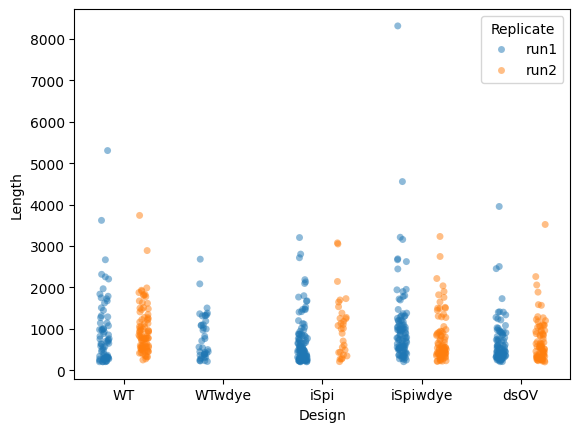

In [9]:
# sns.violinplot(data=filtered_data.select('Design','Length','Run'), x='Design', y='Length',  
#                inner="quart", density_norm='area', 
#                hue='Design', alpha = .8)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Define the order of the categories
order = ['WT', 'WTwdye', 'iSpi', 'iSpiwdye','dsOV']  # Replace with your actual design names

# Define the color palette
sns.stripplot(x='Design', y='Length', hue = 'Replicate', data=filtered_data, 
              dodge=True, jitter=True, alpha=0.5, order=order)

#export to svg
plt.savefig("length.svg")
# sns.boxplot(x='Design', y='Length', data=filtered_data)
# plt.yticks(np.arange(0, 4000, step=250))

<Axes: xlabel='Design', ylabel='Length'>

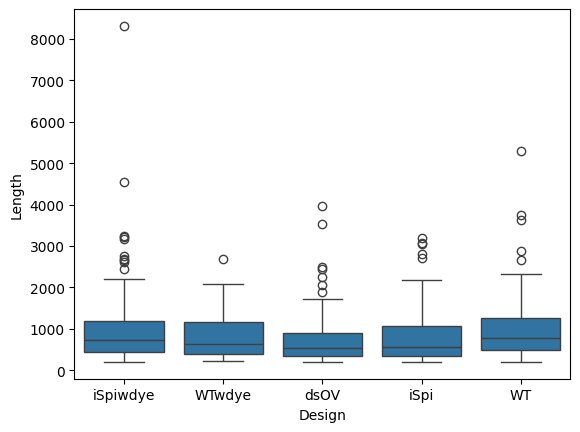

In [10]:
sns.boxplot(x='Design', y='Length', data=filtered_data)

MSED method pL calculations


dsOV
[819.00851212] [34.22326805]
149 159


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


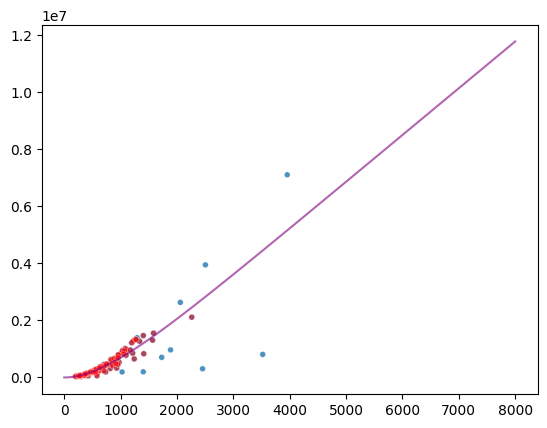

WTwdye
[2601.73047434] [100.66483322]
33 38


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


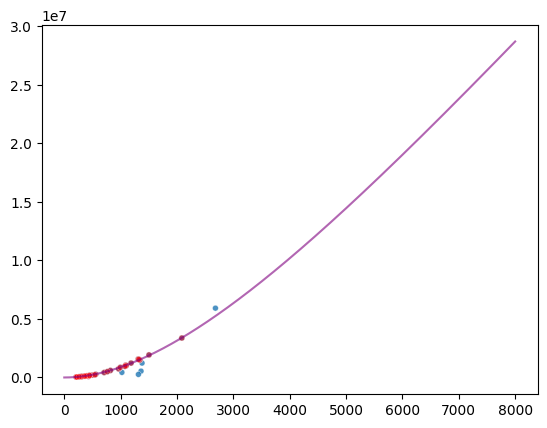

/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


WT
[3431.00629148] [125.5186853]
141 152


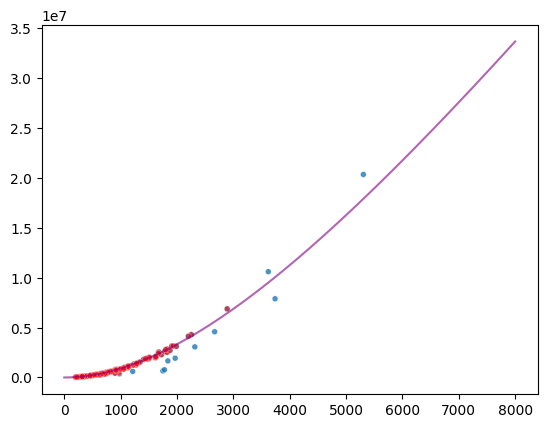

iSpi
[1312.81090871] [70.51673441]
124 133


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


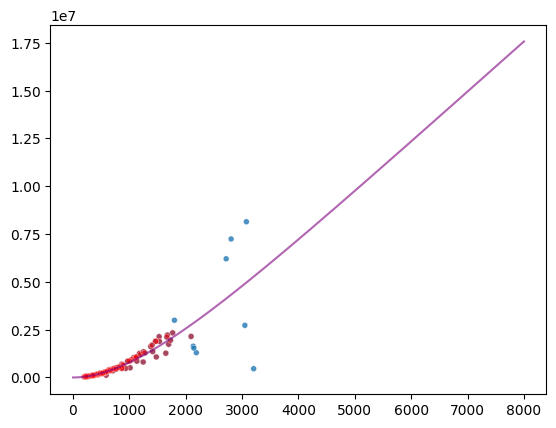

iSpiwdye
[1003.86044212] [34.69222344]
162 175


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_21864/995129885.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


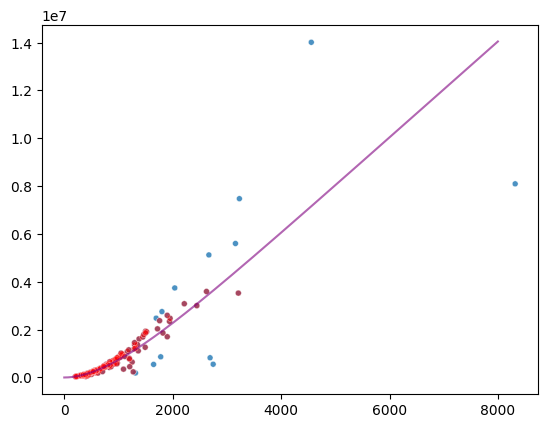

In [13]:
grouped_filtered = filtered_data.group_by(['Design'])

for group_key, group_df in grouped_filtered: #group_key is a tuple ('Imagename', Contour ID) and group_df is the df of with the group_key
    design= group_key[0]
    # print(group_df)
    print(design)
    
    #Extract the data
    Rsq = np.array(group_df['Rsq'])
    # print(Rsq)
    length = np.array(group_df['Length'])
    sns.scatterplot(x=length,y=Rsq,size=1,alpha=.8)

    #Fit the data 
    s=1 #according to the model https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5597049/
    def plRsq(x,P):
        return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
    
    testpl, cov = curve_fit(plRsq, length, Rsq) 
    # print(design,testpl)
    fit_y = plRsq(np.array(length),testpl)
    
    # 
    #Remove outlier
    # Calculate residuals
    residuals = Rsq - fit_y
    # print(residuals)

    # Calculate mean and standard deviation of residuals
    mean_residuals = np.mean(residuals)
    std_residuals = np.std(residuals)
    #  Mask data points where residuals > 1 * std_residuals
    mask = np.abs(residuals) <= 1*std_residuals
    # Apply mask to x and y
    x_masked = np.asarray(length)[mask]
    y_masked = np.asarray(Rsq)[mask]
    #Plot the masked data
    testpl_mask, cov_mask =curve_fit(plRsq, x_masked, y_masked) 
    print(testpl_mask,np.sqrt(np.diag(cov_mask)))
    print(len(x_masked),len(length))
    fit_y_masked = plRsq(np.array(x_masked),testpl_mask)
  
    sns.scatterplot(x=x_masked,y=y_masked,size=1,alpha=.5, color = 'red')
    sns.lineplot(x=np.arange(0,8000),y=plRsq(np.arange(0,8000),testpl_mask),alpha=.6,color = 'purple')
    # sns.lineplot(x=x_masked,y=fit_y_masked,alpha=.8,color = 'red')
    


    plt.legend([],[], frameon=False)
    plt.show()  



dsOV
run2
[521.96798118] [37.78847349]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


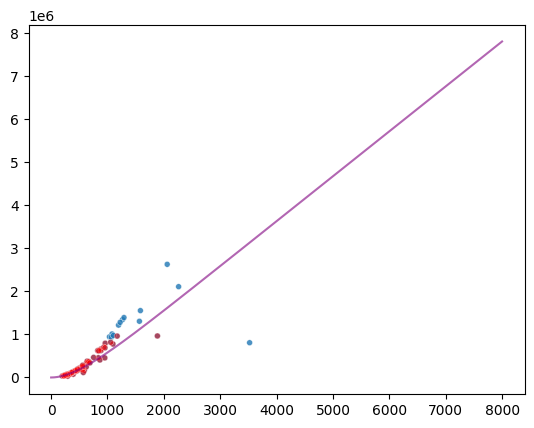

WT
run2
[2350.57152151] [85.82573114]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


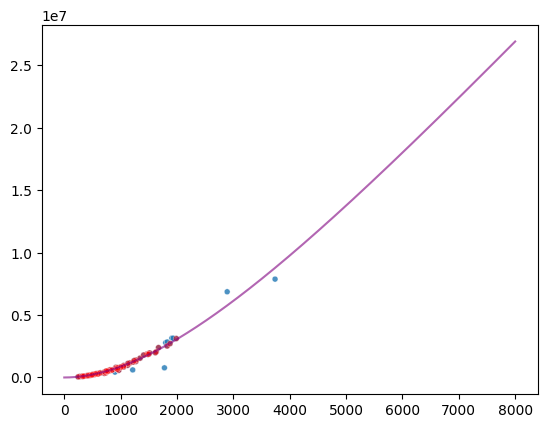

WTwdye
run1
[2601.73046543] [100.66481365]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


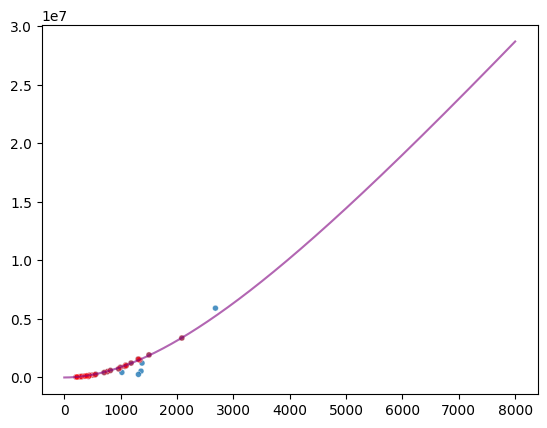

WT
run1
[4852.16670843] [202.51007223]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


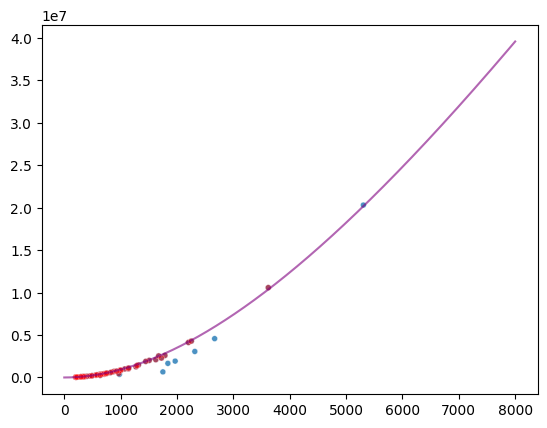

iSpi
run2
[1172.12418109] [120.74382339]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


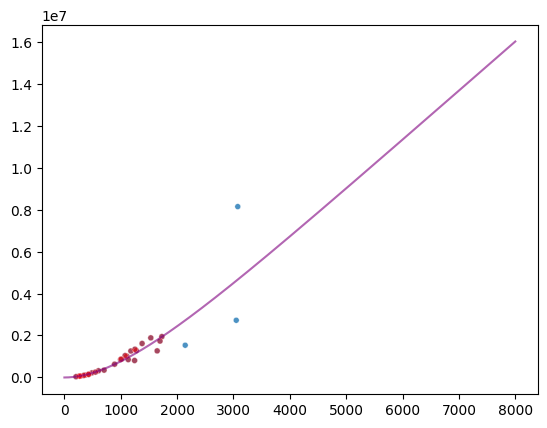

iSpiwdye
run2
[1448.11164338] [66.10631513]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


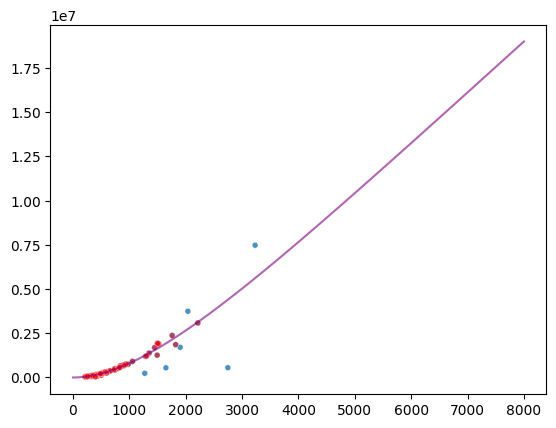

/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


dsOV
run1
[956.13712543] [75.67140529]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


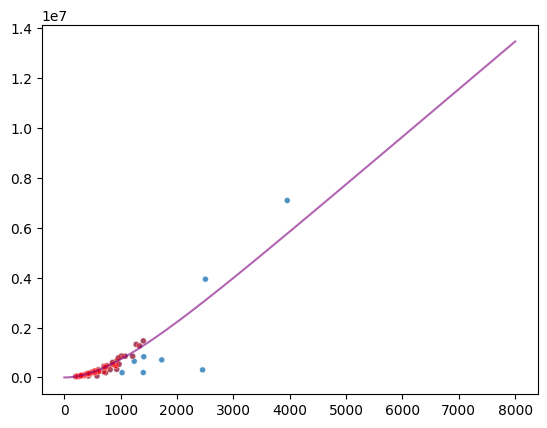

iSpiwdye
run1
[951.64241425] [52.11822921]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


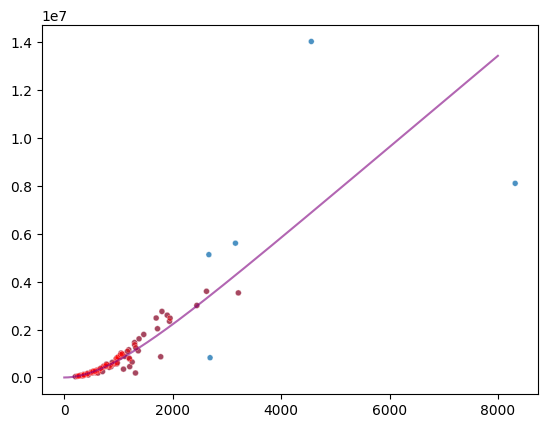

iSpi
run1
[1399.67775043] [89.46509891]


/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: divide by zero encountered in divide
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
/var/folders/71/fj0d3hg915n7zlmz97_f8dt40000gq/T/ipykernel_17721/2073522432.py:17: RuntimeWarning: invalid value encountered in multiply
  return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))


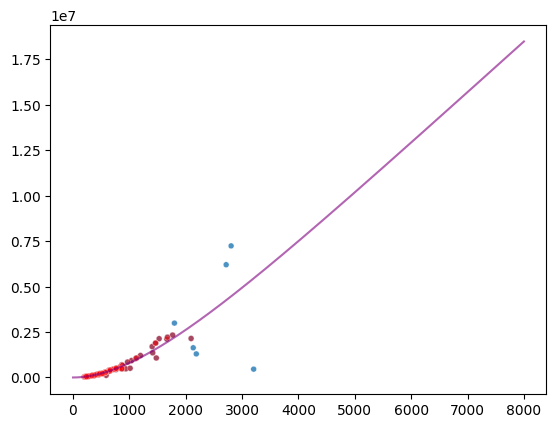

In [94]:
grouped_filtered_run = filtered_data.group_by(['Design','Replicate'])
for group_key, group_df in grouped_filtered_run: #group_key is a tuple ('Imagename', Contour ID) and group_df is the df of with the group_key
    design= group_key[0]
    # print(group_df)
    print(design)
    print(group_key[1])
    
    #Extract the data
    Rsq = np.array(group_df['Rsq'])
    # print(Rsq)
    length = np.array(group_df['Length'])
    sns.scatterplot(x=length,y=Rsq,size=1,alpha=.8)

    #Fit the data 
    s=1 #according to the model https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5597049/
    def plRsq(x,P):
        return 2*s*P*x*(1-(s*P/x*(1-np.exp(-x/(s*P)))))
    
    testpl, cov = curve_fit(plRsq, length, Rsq) 
    # print(design,testpl)
    fit_y = plRsq(np.array(length),testpl)
    
    # 
    #Remove outlier
    # Calculate residuals
    residuals = Rsq - fit_y
    # print(residuals)

    # Calculate mean and standard deviation of residuals
    mean_residuals = np.mean(residuals)
    std_residuals = np.std(residuals)
    #  Mask data points where residuals > 1 * std_residuals
    mask = np.abs(residuals) <= 1*std_residuals
    # Apply mask to x and y
    x_masked = np.asarray(length)[mask]
    y_masked = np.asarray(Rsq)[mask]
    #Plot the masked data
    testpl_mask, cov_mask =curve_fit(plRsq, x_masked, y_masked) 
    print(testpl_mask,np.sqrt(np.diag(cov_mask)))
    fit_y_masked = plRsq(np.array(x_masked),testpl_mask)
  
    sns.scatterplot(x=x_masked,y=y_masked,size=1,alpha=.5, color = 'red')
    sns.lineplot(x=np.arange(0,8000),y=plRsq(np.arange(0,8000),testpl_mask),alpha=.6,color = 'purple')
    # sns.lineplot(x=x_masked,y=fit_y_masked,alpha=.8,color = 'red')
    


    plt.legend([],[], frameon=False)
    plt.show()  